## [Main Config]()

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import pandas as pd

import gym
from gym.spaces import Discrete, Tuple, MultiDiscrete
import math
import matplotlib.pyplot as plt


# Define the initial true price, initial spread
p_ext = 1000
spread = 2

# Define other env params
mu = 18
spread_exp = 1  # spread penalty = - mu * (spread)^(spread_exp)

max_history_len = 21 # history over which imbalance calculated
max_episode_len = 20000 # number of time slots
max_episodes = 100 # number of episodes
average_over_episodes = True # Plot average over episodes?
ema_base = -1 #0.97 # exponential moving average - set to -1 if want to use moving window instead

informed = 0.9 # ALPHA : percentage of informed traders
vary_informed = False


jump_prob = 0.9 # SIGMA : probability of price jump for fixed trade size model
jump_variance = 25 # SIGMA : variance of jump for variable trade size model
vary_jump_prob = False
jump_size = 1
jump_at = -100000 # = -1 if no jumps, if positive, then jumps at that time by 1000*jump_size and stays constant

use_short_term = True # use short term imbalance ?
use_endogynous = True # use endogynous variables or exogenous

n_price_adjustments = 3 # number of actions of agent to increase/decrease mid price

adjust_mid_spread = True # adjust mid + spread or adjust bid, ask separately
fixed_spread = False # fix the spread?
use_stored_path = True # use a stored sample path again?
# if vary_informed or vary_jump_prob:
#     use_stored_path = False # use a stored sample path again?


# Compare with !use_endogynous ?
compare = True
# Compare with bayesian policy ?
compare_with_bayes = True

special_string = None
model_transfer = False # set to True if you are reusing the same agent - modify the special string above to indicate that

# Define type of the RL agent 
agent_type = "QT" # BA = Bayesian, QT = q learning using table, QUCB = q learning with UCB and table, DQN = deep q network, SARSA = sarsa dq

state_is_vec = False
# Define agent params
alpha = 0.06 # learning rate
gamma = 0.99 # discount rate of future rewards
epsilon = 0.99 # probability of exploration vs exploitation - decays over time, this is only the starting epsilon
c = 0.001 # UCB factor
if model_transfer:
    epsilon = 0.1
    
# Define plot params
moving_avg = int(max_episode_len/200)
if moving_avg < 10:
    moving_avg = 1
mode="valid"

# General trader models
noise_type = "Bernoulli" # "Bernoulli", "Gaussian", "Laplacian", "GeomGaussian"
noise_mean = 0
noise_variance = 1

# Variable trade size parameters
do_variable_trade_size = False
normal_AMM = False # If true then bayesian amm is static and not dynamic. If false then behaves like a bayesian AMM
compare_with_normal = False
max_trade_size = 1
n_slippage_adjustments = 3
slippage = 0.1


## Environment setup

In [2]:
from env import GlostenMilgromEnv, bayesian_demand_curve, discretized_gaussian

## Agent setup

In [3]:
from agent import DQN_Agent,QLearningAgent,QLearningAgentUpperConf,BayesianAgent, save_checkpoint, load_checkpoint

## Create agent and environment

In [4]:
# Create the environment
env = GlostenMilgromEnv(
    p_ext, 
    spread, 
    mu, 
    jump_prob=jump_prob,
    jump_variance=jump_variance,
    informed=informed, 
    max_episode_len=max_episode_len, 
    max_history_len=max_history_len,
    use_short_term=use_short_term,
    use_endogynous=use_endogynous,
    n_price_adjustments=n_price_adjustments,
    adjust_mid_spread=adjust_mid_spread,
    fixed_spread=fixed_spread,
    use_stored_path=use_stored_path,
    spread_exp=spread_exp,
    jump_size=jump_size,
    vary_informed=vary_informed,
    vary_jump_prob=vary_jump_prob,
    ema_base=ema_base,
    compare_with_bayes = compare_with_bayes,
    jump_at=jump_at,
    noise_type=noise_type,
    noise_variance=noise_variance,
    n_slippage_adjustments=n_slippage_adjustments,
    max_trade_size=max_trade_size,
    slippage=slippage,
    normal_AMM=normal_AMM
)

env_compare = GlostenMilgromEnv(
    p_ext, 
    spread, 
    mu, 
    jump_prob=jump_prob,
    jump_variance=jump_variance,
    informed=informed, 
    max_episode_len=max_episode_len, 
    max_history_len=max_history_len,
    use_short_term=use_short_term,
    use_endogynous=not use_endogynous,
    n_price_adjustments=n_price_adjustments,
    adjust_mid_spread=adjust_mid_spread,
    fixed_spread=fixed_spread,
    use_stored_path=use_stored_path,
    spread_exp=spread_exp,
    jump_size=jump_size,
    vary_informed=vary_informed,
    vary_jump_prob=vary_jump_prob,
    ema_base=ema_base,
    compare_with_bayes = compare_with_bayes,
    jump_at=jump_at,
    noise_type=noise_type,
    noise_variance=noise_variance,
    n_slippage_adjustments=n_slippage_adjustments,
    max_trade_size=max_trade_size,
    slippage=slippage,
    normal_AMM=normal_AMM
)

env_bayes = GlostenMilgromEnv(
    p_ext, 
    spread, 
    mu, 
    jump_prob=jump_prob,
    jump_variance=jump_variance,
    informed=informed, 
    max_episode_len=max_episode_len, 
    max_history_len=max_history_len,
    use_short_term=use_short_term,
    use_endogynous=use_endogynous,
    n_price_adjustments=n_price_adjustments,
    adjust_mid_spread=adjust_mid_spread,
    fixed_spread=fixed_spread,
    use_stored_path=use_stored_path,
    spread_exp=spread_exp,
    jump_size=jump_size,
    vary_informed=vary_informed,
    vary_jump_prob=vary_jump_prob,
    ema_base=ema_base,
    compare_with_bayes = compare_with_bayes,
    jump_at=jump_at,
    noise_type=noise_type,
    noise_variance=noise_variance,
    n_slippage_adjustments=n_slippage_adjustments,
    max_trade_size=max_trade_size,
    slippage=slippage,
    normal_AMM=normal_AMM
)
# Create the agent


if model_transfer:
    if agent_type == "DQN" or agent_type == "PPO":
        state_is_vec = True
else:
    if agent_type == "QT": # tabular q learning with epsilon exploration
        n_states = 2*max_history_len + 1  # Define the number of discrete states for the given history window
        if do_variable_trade_size:
            agent = QLearningAgent(
                n_actions=[env.action_space[0].n,env.action_space[1].n,env.n_slippage_adjustments], 
                n_states=n_states, 
                alpha=alpha, 
                gamma=gamma, 
                epsilon=epsilon,
                variable_trade_size=True
            )
            comparison_agent = QLearningAgent(
                n_actions=[env.action_space[0].n,env.action_space[1].n,env.n_slippage_adjustments], 
                n_states=n_states, 
                alpha=alpha, 
                gamma=gamma, 
                epsilon=epsilon,
                variable_trade_size=True
            )
        else:
            agent = QLearningAgent(
                n_actions=[env.action_space[0].n,env.action_space[1].n], 
                n_states=n_states, 
                alpha=alpha, 
                gamma=gamma, 
                epsilon=epsilon
            )
            comparison_agent = QLearningAgent(
                n_actions=[env.action_space[0].n,env.action_space[1].n], 
                n_states=n_states, 
                alpha=alpha, 
                gamma=gamma, 
                epsilon=epsilon
            )
    elif agent_type == "QUCB": # tabular q learning + ucb exploration
        n_states = 2*max_history_len + 1  # Define the number of discrete states for the given history window
        agent = QLearningAgentUpperConf(
            n_actions=[env.action_space[0].n,env.action_space[1].n], 
            n_states=n_states, 
            alpha=alpha, 
            gamma=gamma, 
            c=c
        )
        comparison_agent = QLearningAgentUpperConf(
            n_actions=[env.action_space[0].n,env.action_space[1].n], 
            n_states=n_states, 
            alpha=alpha, 
            gamma=gamma, 
            c=c
        )
    elif agent_type == "DQN":
        state_dim = 1
        state_is_vec = True
        agent = DQN_Agent(
            max_history_len,
            n_price_adjustments,
            num_adjustments=n_price_adjustments,
            window=max_history_len,
            hidden_size=64,
            lr=1e-3,
            gamma=gamma,
            epsilon_start=1.0,
            epsilon_end=0.01,
            epsilon_decay=0.995
        )
    elif agent_type == "SARSA":
        state_dim = 1
        agent = SARSA_agent(
            n_actions=[env.action_space[0].n,env.action_space[1].n],
            state_dim=state_dim,
            alpha=alpha,
            gamma=gamma,
            epsilon=epsilon
        )
    elif agent_type == "UCRL":
        pass
    elif agent_type == "TD":
        pass
    elif agent_type == "AI":
        pass
    elif agent_type == "BA":
        n_states = 2*max_history_len + 1
        agent = BayesianAgent(
            n_actions=[env.action_space[0].n,env.action_space[1].n], 
            n_states=n_states, 
            alpha=alpha, 
            gamma=gamma, 
            epsilon=epsilon
        )
    else:
        print("ERROR_UNKNOWN_AGENT_TYPE")
 

In [5]:
       
    if compare_with_bayes or compare_with_normal:
        n_states_bayes = 2*max_history_len + 1
        bayesian_agent = BayesianAgent(
            n_actions=[env.action_space[0].n,env.action_space[1].n], 
            n_states=n_states_bayes, 
            alpha=alpha, 
            gamma=gamma, 
            epsilon=epsilon
        )

## Train and test agent on environment

In [6]:
import os

# Train the agent for some number of episodes - ideally should only need one episode for training the network
# output detailed plots for the last episode

total_rewards = []
monetary_losses = []

total_rewards_compare = []
monetary_losses_compare = []



rewards_vs_time = [0.0]
monetary_losses_vs_time = [0.0]
spread_vs_time = []
ask_vs_time = []
bid_vs_time = []
mid_price_vs_time = []

rewards_vs_time_compare = [0.0]
monetary_losses_vs_time_compare = [0.0]
spread_vs_time_compare = []
ask_vs_time_compare = []
bid_vs_time_compare = []
mid_price_vs_time_compare = []

total_rewards_bayes = []
monetary_losses_bayes = []
rewards_vs_time_bayes = [0.0]
monetary_losses_vs_time_bayes = [0.0]
spread_vs_time_bayes = []
ask_vs_time_bayes = []
bid_vs_time_bayes = []
mid_price_vs_time_bayes = []


p_ext_vs_time = []
price_of_ask_over_time = []

def normalize_trade_imbalance(imbalance, n_states):
    return min(max(int(imbalance + n_states // 2), 0), n_states - 1)


if not state_is_vec:
    n_states = agent.n_states

    
for episode in (range(max_episodes)):
    
    print("Episode ",episode)
    env.reset()
    env.resetAllVars(reset_stored_path=True)
    
    env_compare.reset()
    env_compare.resetAllVars(reset_stored_path=False)
    
    env_bayes.reset()
    env_bayes.resetAllVars(reset_stored_path=False)
    
    env_compare.price_path = env.price_path
    env_bayes.price_path = env.price_path
    
    env_compare.trader_price_path = env.trader_price_path
    env_bayes.trader_price_path = env.trader_price_path
    
    if not state_is_vec:
        state = normalize_trade_imbalance(env.imbalance, n_states)
        state_compare = normalize_trade_imbalance(env_compare.imbalance, n_states)
    else:
        state = torch.zeros(1,max_history_len)
        state_compare = torch.zeros(1,max_history_len)
    
    state_bayes = normalize_trade_imbalance(env_bayes.imbalance, n_states)
    
    done = False
    
    total_reward = 0
    total_reward_compare = 0
    total_reward_bayes = 0
    
    time = 0

    while not done:
        action = agent.choose_action(state,epsilon=agent.epsilon**time)
        
        if do_variable_trade_size:
            (next_trade_history, next_imbalance), reward, done, extra_dict = env.step_variable(action)
        else:
            (next_trade_history, next_imbalance), reward, done, extra_dict = env.step(action)
        if state_is_vec:
            next_state = torch.tensor(next_trade_history).permute((1,0)).float()
            agent.update(state, action, reward, next_state, done=done)
        else:
            next_state = normalize_trade_imbalance(next_imbalance, n_states)
            agent.update(state, action, reward, next_state)

        state = next_state
        total_reward += reward
        time += 1
        
        if not average_over_episodes:
            if episode == max_episodes-1:
                p_ext_vs_time.append(extra_dict["p_ext"])
                rewards_vs_time.append(reward)
                monetary_losses_vs_time.append(extra_dict["monetary_loss"])
                spread_vs_time.append(extra_dict["spread"])
                ask_vs_time.append(extra_dict["ask"])
                bid_vs_time.append(extra_dict["bid"])
                mid_price_vs_time.append(extra_dict["mid"])
                #print(time," : {0},{1}".format(extra_dict["ask"],extra_dict["bid"]))
        else:
            if episode == 0:
                p_ext_vs_time.append(extra_dict["p_ext"])
                rewards_vs_time.append(reward)
                monetary_losses_vs_time.append(extra_dict["monetary_loss"])
                spread_vs_time.append(extra_dict["spread"])
                ask_vs_time.append(extra_dict["ask"])
                bid_vs_time.append(extra_dict["bid"])
                mid_price_vs_time.append(extra_dict["mid"])
                #print(time," : {0},{1}".format(extra_dict["ask"],extra_dict["bid"]))
            else:
                p_ext_vs_time[time-1] += (extra_dict["p_ext"])
                rewards_vs_time[time-1] +=(reward)
                monetary_losses_vs_time[time-1] +=(extra_dict["monetary_loss"])
                spread_vs_time[time-1] +=(extra_dict["spread"])
                ask_vs_time[time-1] +=(extra_dict["ask"])
                bid_vs_time[time-1] +=(extra_dict["bid"])
                mid_price_vs_time[time-1] +=(extra_dict["mid"])
            if episode == max_episodes-1:
                p_ext_vs_time[time-1] /= max_episodes
                rewards_vs_time[time-1] /= max_episodes
                monetary_losses_vs_time[time-1] /= max_episodes
                spread_vs_time[time-1] /= max_episodes
                ask_vs_time[time-1] /= max_episodes
                bid_vs_time[time-1] /= max_episodes
                mid_price_vs_time[time-1] /= max_episodes
    
        if compare:
            action = comparison_agent.choose_action(state_compare,epsilon=epsilon**time)

            if do_variable_trade_size:
                (next_trade_history, next_imbalance), reward, done, extra_dict = env_compare.step_variable(action)
            else:
                (next_trade_history, next_imbalance), reward, done, extra_dict = env_compare.step(action)

            next_state_compare = normalize_trade_imbalance(next_imbalance, n_states)

            comparison_agent.update(state_compare, action, reward, next_state_compare)

            state_compare = next_state_compare
            total_reward_compare += reward

            if not average_over_episodes:
                if episode == max_episodes-1:
                    #p_ext_vs_time_compare.append(extra_dict["p_ext"])
                    rewards_vs_time_compare.append(reward)
                    monetary_losses_vs_time_compare.append(extra_dict["monetary_loss"])
                    spread_vs_time_compare.append(extra_dict["spread"])
                    ask_vs_time_compare.append(extra_dict["ask"])
                    bid_vs_time_compare.append(extra_dict["bid"])
                    mid_price_vs_time_compare.append(extra_dict["mid"])
                    #print(time," : {0},{1}".format(extra_dict["ask"],extra_dict["bid"]))
            else:
                if episode == 0:
                    #p_ext_vs_time_compare.append(extra_dict["p_ext"])
                    rewards_vs_time_compare.append(reward)
                    monetary_losses_vs_time_compare.append(extra_dict["monetary_loss"])
                    spread_vs_time_compare.append(extra_dict["spread"])
                    ask_vs_time_compare.append(extra_dict["ask"])
                    bid_vs_time_compare.append(extra_dict["bid"])
                    mid_price_vs_time_compare.append(extra_dict["mid"])
                    #print(time," : {0},{1}".format(extra_dict["ask"],extra_dict["bid"]))
                else:
                    #p_ext_vs_time_compare[time-1] += (extra_dict["p_ext"])
                    rewards_vs_time_compare[time-1] +=(reward)
                    monetary_losses_vs_time_compare[time-1] +=(extra_dict["monetary_loss"])
                    spread_vs_time_compare[time-1] +=(extra_dict["spread"])
                    ask_vs_time_compare[time-1] +=(extra_dict["ask"])
                    bid_vs_time_compare[time-1] +=(extra_dict["bid"])
                    mid_price_vs_time_compare[time-1] +=(extra_dict["mid"])
                if episode == max_episodes-1:
                    #p_ext_vs_time_compare[time-1] /= max_episodes
                    rewards_vs_time_compare[time-1] /= max_episodes
                    monetary_losses_vs_time_compare[time-1] /= max_episodes
                    spread_vs_time_compare[time-1] /= max_episodes
                    ask_vs_time_compare[time-1] /= max_episodes
                    bid_vs_time_compare[time-1] /= max_episodes
                    mid_price_vs_time_compare[time-1] /= max_episodes
        if compare_with_bayes or compare_with_normal :
            if compare_with_normal:
                env_bayes.normal_AMM = True                
            action = bayesian_agent.choose_action(state_bayes,epsilon=epsilon**time)
            
            if do_variable_trade_size:
                (next_trade_history, next_imbalance), reward, done, extra_dict = env_bayes.step_variable(action)
            else:
                (next_trade_history, next_imbalance), reward, done, extra_dict = env_bayes.step(action)

            next_state_bayes = normalize_trade_imbalance(next_imbalance, n_states)

            bayesian_agent.update(state_bayes, action, reward, next_state_bayes)

            state_bayes = next_state_bayes
            total_reward_bayes += reward

            if not average_over_episodes:
                if episode == max_episodes-1:
                    #p_ext_vs_time_bayes.append(extra_dict["p_ext"])
                    rewards_vs_time_bayes.append(reward)
                    monetary_losses_vs_time_bayes.append(extra_dict["monetary_loss"])
                    spread_vs_time_bayes.append(extra_dict["spread"])
                    ask_vs_time_bayes.append(extra_dict["ask"])
                    bid_vs_time_bayes.append(extra_dict["bid"])
                    mid_price_vs_time_bayes.append(extra_dict["mid"])
                    #print(time," : {0},{1}".format(extra_dict["ask"],extra_dict["bid"]))
            else:
                if episode == 0:
                    #p_ext_vs_time_bayes.append(extra_dict["p_ext"])
                    rewards_vs_time_bayes.append(reward)
                    monetary_losses_vs_time_bayes.append(extra_dict["monetary_loss"])
                    spread_vs_time_bayes.append(extra_dict["spread"])
                    ask_vs_time_bayes.append(extra_dict["ask"])
                    bid_vs_time_bayes.append(extra_dict["bid"])
                    mid_price_vs_time_bayes.append(extra_dict["mid"])
                    #print(time," : {0},{1}".format(extra_dict["ask"],extra_dict["bid"]))
                else:
                    #p_ext_vs_time_bayes[time-1] += (extra_dict["p_ext"])
                    rewards_vs_time_bayes[time-1] +=(reward)
                    monetary_losses_vs_time_bayes[time-1] +=(extra_dict["monetary_loss"])
                    spread_vs_time_bayes[time-1] +=(extra_dict["spread"])
                    ask_vs_time_bayes[time-1] +=(extra_dict["ask"])
                    bid_vs_time_bayes[time-1] +=(extra_dict["bid"])
                    mid_price_vs_time_bayes[time-1] +=(extra_dict["mid"])
                if episode == max_episodes-1:
                    #p_ext_vs_time_bayes[time-1] /= max_episodes
                    rewards_vs_time_bayes[time-1] /= max_episodes
                    monetary_losses_vs_time_bayes[time-1] /= max_episodes
                    spread_vs_time_bayes[time-1] /= max_episodes
                    ask_vs_time_bayes[time-1] /= max_episodes
                    bid_vs_time_bayes[time-1] /= max_episodes
                    mid_price_vs_time_bayes[time-1] /= max_episodes
                        
    total_rewards.append(total_reward)
    monetary_losses.append(env.cumulative_monetary_loss)
    if compare:
        total_rewards_compare.append(total_reward_compare)
        monetary_losses_compare.append(env_compare.cumulative_monetary_loss)
    if compare_with_bayes:
        total_rewards_bayes.append(total_reward_bayes)
        monetary_losses_bayes.append(env_bayes.cumulative_monetary_loss)


Episode  0
Episode  1
Episode  2
Episode  3
Episode  4
Episode  5
Episode  6
Episode  7
Episode  8
Episode  9
Episode  10
Episode  11
Episode  12
Episode  13
Episode  14
Episode  15
Episode  16
Episode  17
Episode  18
Episode  19
Episode  20
Episode  21
Episode  22
Episode  23
Episode  24
Episode  25
Episode  26
Episode  27
Episode  28
Episode  29
Episode  30
Episode  31
Episode  32
Episode  33
Episode  34
Episode  35
Episode  36
Episode  37
Episode  38
Episode  39
Episode  40
Episode  41
Episode  42
Episode  43
Episode  44
Episode  45
Episode  46
Episode  47
Episode  48
Episode  49
Episode  50
Episode  51
Episode  52
Episode  53
Episode  54
Episode  55
Episode  56
Episode  57
Episode  58
Episode  59
Episode  60
Episode  61
Episode  62
Episode  63
Episode  64
Episode  65
Episode  66
Episode  67
Episode  68
Episode  69
Episode  70
Episode  71
Episode  72
Episode  73
Episode  74
Episode  75
Episode  76
Episode  77
Episode  78
Episode  79
Episode  80
Episode  81
Episode  82
Episode  83
Ep

## Make and save the plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Average total reward main: -222.3331075
Average monetary loss main : -3.8463269999999996
Mean spread main 5.209547522623869
Mean mid dev main 0.764285785710714
Average total reward compare: -45.56245175
Average monetary loss compare: -3.23600075
Average total reward reference: -63.883359
Average monetary loss reference: -0.0801165
Mean spread reference 3.0149692515374227
Mean mid dev reference 0.12844657767111683


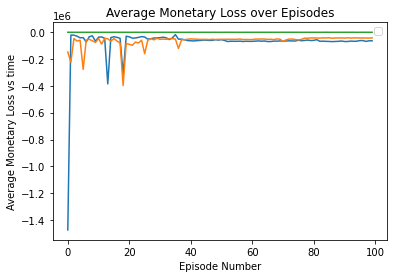

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


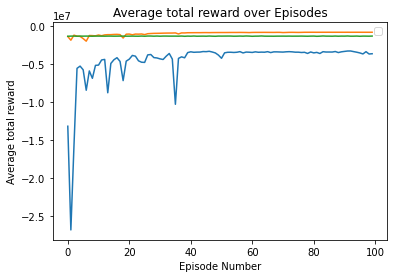

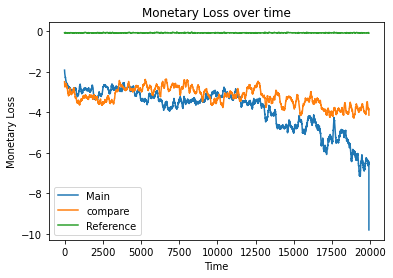

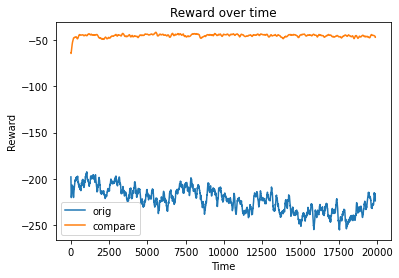

Spread over time : one sample path


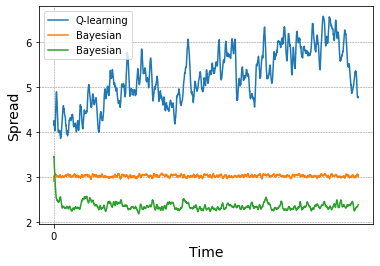

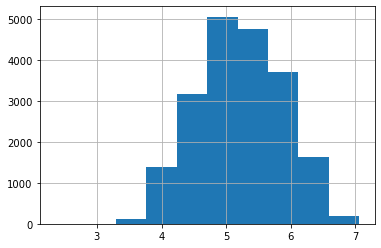

Q-learning Ask and Bid over time : one sample path


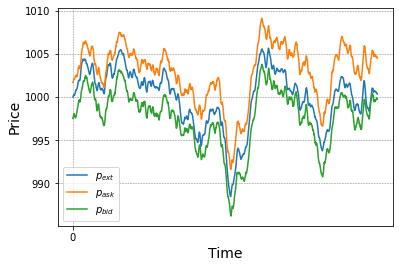

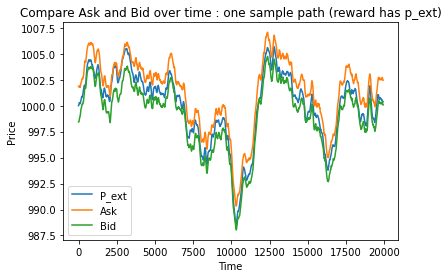

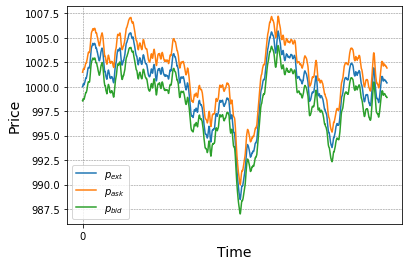

mid price deviation


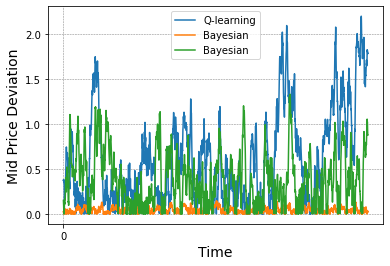

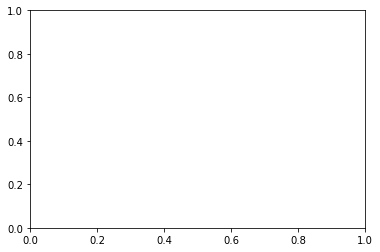

In [7]:
if noise_type == "Bernoulli":
    figure_path = "modelFreeGM/informed_{0}_jump_{1}_mu_{2}/fixedSpread_{10}_useShortTerm_{3}_useEndo_{4}_maxHistoryLen_{5}/agentType_{6}_alpha_{7}_gamma_{8}_epsilon_{9}".format(
        informed,
        jump_prob,
        mu,
        use_short_term,
        use_endogynous,
        max_history_len,
        agent_type,
        alpha,
        gamma,
        epsilon,
        fixed_spread
    )
else:
    figure_path = "modelFreeGM/{0}_{10}_jump_{1}_mu_{2}/fixedSpread_{10}_useShortTerm_{3}_useEndo_{4}_maxHistoryLen_{5}/agentType_{6}_alpha_{7}_gamma_{8}_epsilon_{9}".format(
        noise_type,
        jump_prob,
        mu,
        use_short_term,
        use_endogynous,
        max_history_len,
        agent_type,
        alpha,
        gamma,
        epsilon,
        fixed_spread,
        noise_variance
    ) 
if special_string is not None:
    figure_path = figure_path + "/{0}".format(special_string)

if ema_base != -1:
    figure_path = figure_path + "/ema_base_{0}".format(ema_base)
    
if not adjust_mid_spread:
    figure_path = figure_path + "/direct_ask_bid_control"

os.makedirs(figure_path , exist_ok=True)

# Calculate the average total reward and monetary loss
average_total_reward = np.mean(total_rewards)
average_monetary_loss = np.mean(monetary_losses)
print("Average total reward main:", average_total_reward/max_episode_len)
print("Average monetary loss main :", average_monetary_loss/max_episode_len)
print("Mean spread main",np.mean(np.array(spread_vs_time)))
print("Mean mid dev main",np.mean(abs(np.array(mid_price_vs_time)-np.array(p_ext_vs_time))))
print(" ")
if compare:
    average_total_reward_compare = np.mean(total_rewards_compare)
    average_monetary_loss_compare = np.mean(monetary_losses_compare)
    print("Average total reward compare:", average_total_reward_compare/max_episode_len)
    print("Average monetary loss compare:", average_monetary_loss_compare/max_episode_len)
    print("Mean spread reference",np.mean(np.array(spread_vs_time_bayes)))
    print("Mean mid dev reference",np.mean(abs(np.array(mid_price_vs_time_bayes)-np.array(p_ext_vs_time))))
    print(" ")
if compare_with_bayes or compare_with_normal:
    average_total_reward_bayes = np.mean(total_rewards_bayes)
    average_monetary_loss_bayes = np.mean(monetary_losses_bayes)
    print("Average total reward reference:", average_total_reward_bayes/max_episode_len)
    print("Average monetary loss reference:", average_monetary_loss_bayes/max_episode_len)
    print("Mean spread reference",np.mean(np.array(spread_vs_time_bayes)))
    print("Mean mid dev reference",np.mean(abs(np.array(mid_price_vs_time_bayes)-np.array(p_ext_vs_time))))
    print(" ")

# Plot the average monetary loss over all episodes
plt.plot(monetary_losses)
if compare:
    plt.plot(monetary_losses_compare)
if compare_with_bayes or compare_with_normal:
    plt.plot(monetary_losses_bayes)
plt.xlabel("Episode Number")
plt.ylabel("Average Monetary Loss vs time")
plt.title("Average Monetary Loss over Episodes")
plt.legend()
filename = "Monetary_Loss.pdf"
file_path = os.path.join(figure_path, filename)
plt.savefig(file_path)  
plt.show()
 

# Plot the average total reward over all episodes
plt.plot(total_rewards)
if compare:
    plt.plot(total_rewards_compare)
if compare_with_bayes or compare_with_normal:
    plt.plot(total_rewards_bayes)
plt.xlabel("Episode Number")
plt.ylabel("Average total reward")
plt.title("Average total reward over Episodes")
plt.legend()
filename = "Total_Reward.pdf"
file_path = os.path.join(figure_path, filename)
plt.savefig(file_path)
plt.show()



# Plot the monetary loss over time for the last episode
plt.plot(np.convolve(np.array(monetary_losses_vs_time),np.ones(moving_avg)/moving_avg,mode=mode),label="Main")
if compare:
    plt.plot(np.convolve(np.array(monetary_losses_vs_time_compare),np.ones(moving_avg)/moving_avg,mode=mode),label="compare")
if compare_with_bayes or compare_with_normal:
    plt.plot(np.convolve(np.array(monetary_losses_vs_time_bayes),np.ones(moving_avg)/moving_avg,mode=mode),label="Reference")
plt.xlabel("Time")
plt.ylabel("Monetary Loss")
plt.title("Monetary Loss over time")
plt.legend()
filename = "Loss_Vs_time.pdf"
file_path = os.path.join(figure_path, filename)
plt.savefig(file_path)
plt.show()


# Plot the reward over time for the last episode
plt.plot(np.convolve(np.array(rewards_vs_time),np.ones(moving_avg)/moving_avg,mode=mode),label="orig")
if compare:
    plt.plot(np.convolve(np.array(rewards_vs_time_compare),np.ones(moving_avg)/moving_avg,mode=mode),label="compare")
plt.xlabel("Time")
plt.ylabel("Reward")#
plt.title("Reward over time")
plt.legend()
filename = "Reward_Vs_time.pdf"
file_path = os.path.join(figure_path, filename)
plt.savefig(file_path)
plt.show()


# Plot the spread over time for the last episode
fig, ax = plt.subplots()

ax.plot(np.convolve(np.array(spread_vs_time),np.ones(moving_avg)/moving_avg,mode=mode),label="Q-learning")# spread should decay with time
# if compare:
#     plt.plot(np.convolve(np.array(spread_vs_time_compare),np.ones(moving_avg)/moving_avg,mode=mode),label="compare")# spread should decay with time
if compare_with_bayes or compare_with_normal:
    ax.plot(np.convolve(np.array(spread_vs_time_bayes),np.ones(moving_avg)/moving_avg,mode=mode),label="Bayesian")# spread should decay with time
if compare:
    ax.plot(np.convolve(np.array(spread_vs_time_compare),np.ones(moving_avg)/moving_avg,mode=mode),label="Bayesian")# spread should decay with time

ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Spread', fontsize=14)
ax.xaxis.set_major_locator(plt.MultipleLocator(50000))  # Change 1 to desired x-spacing
#ax.yaxis.set_major_locator(plt.MultipleLocator(1))  # Change 1 to desired y-spacing

print("Spread over time : one sample path")
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

filename = "Spread_Vs_time.pdf"
file_path = os.path.join(figure_path, filename)
fig.savefig(file_path, format='pdf', bbox_inches='tight')
plt.show()

# Plot the spread distribution for the last episode
pd.Series(spread_vs_time).hist()
# if compare:
#     plt.plot(np.convolve(np.array(spread_vs_time_compare),np.ones(moving_avg)/moving_avg,mode=mode),label="compare")# spread should decay with time
# if compare_with_bayes:
#     plt.plot(np.convolve(np.array(spread_vs_time_bayes),np.ones(moving_avg)/moving_avg,mode=mode),label="Bayes")# spread should decay with time
# plt.xlabel("Time")
# plt.ylabel("Spread")
# plt.title("Spread over time : one sample path")
# plt.legend()
# filename = "Spread_Vs_time.pdf"
# file_path = os.path.join(figure_path, filename)
# plt.savefig(file_path)
plt.show()

# Plot the ask,bid and external price over time for the last episode
fig, ax = plt.subplots()

ax.plot(np.convolve(np.array(p_ext_vs_time),np.ones(moving_avg)/moving_avg,mode=mode), label="$p_{ext}$")
ax.plot(np.convolve(np.array(ask_vs_time),np.ones(moving_avg)/moving_avg,mode=mode), label="$p_{ask}$")
ax.plot(np.convolve(np.array(bid_vs_time),np.ones(moving_avg)/moving_avg,mode=mode), label="$p_{bid}$")

ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Price', fontsize=14)

ax.legend()

ax.xaxis.set_major_locator(plt.MultipleLocator(50000))  # Change 1 to desired x-spacing
#ax.yaxis.set_major_locator(plt.MultipleLocator(1))  # Change 1 to desired y-spacing

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

print("Q-learning Ask and Bid over time : one sample path")  # Adjust the title and fontsize as required

filename = "AskBid_Vs_time.pdf"
file_path = os.path.join(figure_path, filename)
fig.savefig(file_path, format='pdf', bbox_inches='tight')

plt.show()

if compare:
    plt.plot(np.convolve(np.array(p_ext_vs_time),np.ones(moving_avg)/moving_avg,mode=mode), label="P_ext")
    plt.plot(np.convolve(np.array(ask_vs_time_compare),np.ones(moving_avg)/moving_avg,mode=mode), label="Ask")
    plt.plot(np.convolve(np.array(bid_vs_time_compare),np.ones(moving_avg)/moving_avg,mode=mode), label="Bid")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title("Compare Ask and Bid over time : one sample path (reward has p_ext)")
    plt.legend()
    filename = "AskBid_Vs_time_compare.pdf"
    file_path = os.path.join(figure_path, filename)
    plt.savefig(file_path)
    plt.show()
if compare_with_bayes or compare_with_normal:
    fig, ax = plt.subplots()

    ax.plot(np.convolve(np.array(p_ext_vs_time),np.ones(moving_avg)/moving_avg,mode=mode), label="$p_{ext}$")
    ax.plot(np.convolve(np.array(ask_vs_time_bayes),np.ones(moving_avg)/moving_avg,mode=mode), label="$p_{ask}$")
    ax.plot(np.convolve(np.array(bid_vs_time_bayes),np.ones(moving_avg)/moving_avg,mode=mode), label="$p_{bid}$")
    
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Price', fontsize=14)
    
    #ax.title("Reference Ask and Bid over time : one sample path")
    ax.xaxis.set_major_locator(plt.MultipleLocator(50000))  # Change 1 to desired x-spacing
    #ax.yaxis.set_major_locator(plt.MultipleLocator(1))  # Change 1 to desired y-spacing
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    filename = "AskBid_Vs_time_bayes.pdf"
    file_path = os.path.join(figure_path, filename)
    plt.savefig(file_path)
    plt.show()

# Plot the mid and ext price over time for the last episode
fig, ax = plt.subplots()

ax.plot(abs(np.convolve((np.array(mid_price_vs_time)-np.array(p_ext_vs_time)),np.ones(moving_avg)/moving_avg,mode=mode)), label="Q-learning")
if compare_with_bayes:
    ax.plot(abs(np.convolve((np.array(mid_price_vs_time_bayes)-np.array(p_ext_vs_time)),np.ones(moving_avg)/moving_avg,mode=mode)), label="Bayesian")# need to make sure E[(mid-p_ext)^2]-> 0 as t becomes large for the last episode
if compare:
    ax.plot(abs(np.convolve((np.array(mid_price_vs_time_compare)-np.array(p_ext_vs_time)),np.ones(moving_avg)/moving_avg,mode=mode)), label="Bayesian")# need to make sure E[(mid-p_ext)^2]-> 0 as t becomes large for the last episode

ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Mid Price Deviation', fontsize=14)

ax.legend()

ax.xaxis.set_major_locator(plt.MultipleLocator(50000))  # Change 1 to desired x-spacing
#ax.yaxis.set_major_locator(plt.MultipleLocator(1))  # Change 1 to desired y-spacing

ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

print("mid price deviation")  # Adjust the title and fontsize as required

filename = "Mid_Vs_time.pdf"
file_path = os.path.join(figure_path, filename)
fig.savefig(file_path, format='pdf', bbox_inches='tight')

plt.show()

fig, ax = plt.subplots()
if env.vary_jump_prob:
    ax.plot(np.convolve(np.array(env.jump_prob_path),np.ones(moving_avg)/moving_avg,mode=mode), label="Volatility")
if env.vary_informed:
    ax.plot(np.convolve(np.array(env.informed_path),np.ones(moving_avg)/moving_avg,mode=mode), label="Informedness")

if env.vary_informed or env.vary_jump_prob:
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Parameter Value', fontsize=14)
    ax.xaxis.set_major_locator(plt.MultipleLocator(50000))  # Change 1 to desired x-spacing
    #ax.yaxis.set_major_locator(plt.MultipleLocator(1))  # Change 1 to desired y-spacing

    #plt.yscale("log")
    print("Variable volatility and informedness")
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

    filename = "Params_Vs_time.pdf"
    file_path = os.path.join(figure_path, filename)
    fig.savefig(file_path, format='pdf', bbox_inches='tight')
    plt.show()
# _______________
# spread_mean=[]
# mid_dev_mean=[]
# alphas=[]
# sigmas=[]

# spread_mean.append(np.mean(np.array(spread_vs_time)))
# mid_dev_mean.append(np.mean(abs(np.array(mid_price_vs_time))))
# alphas.append(informed)
# sigmas.append(jump_prob)
# spread_mean


In [8]:
# spread_mean=[]
# mid_dev_mean=[]
# alphas=[]
# sigmas=[]

In [9]:
spread_mean.append(np.mean(np.array(spread_vs_time)))
mid_dev_mean.append(np.mean(abs(np.array(mid_price_vs_time))))
alphas.append(informed)
sigmas.append(jump_prob)
spread_mean

NameError: name 'spread_mean' is not defined

In [ ]:
print(agent.q_table)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for demonstration
time = np.linspace(0, 10, 100)
price1 = np.sin(time) + time
price2 = np.cos(time) * 0.5
price3 = np.sin(time) * np.cos(time) * 0.5
price4 = np.sin(time) - 0.5

# Create the plot
fig, ax = plt.subplots()

ax.plot(time, price1, label='$p_1$')
ax.plot(time, price2, label='$p_2$')
ax.plot(time, price3, label='$p_3$')
ax.plot(time, price4, label='$p_{ext}$')  # Using mathtext for subscript

# Adjust tick spacing on the x and y axes
ax.xaxis.set_major_locator(plt.MultipleLocator(1))  # Change 1 to desired x-spacing
ax.yaxis.set_major_locator(plt.MultipleLocator(1))  # Change 1 to desired y-spacing

# Add a very light grid on both x and y axes
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Price', fontsize=16)
ax.legend()
plt.show()


In [ ]:
print(np.array(ask_vs_time_bayes))
print(np.array(bid_vs_time_bayes))